# Get stationary time series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm
from random import seed
from cnn_graph.lib import models, graph, coarsening

Using TensorFlow backend.


In [2]:
# Load data
dist_geo = pd.read_csv("data/distance_toulouse.csv",header=0,index_col=0)
X_hour = pd.read_csv("data/X_hour_toulouse.csv",header=0,index_col=0)
T_1, N = X_hour.shape
T_0 = int(T_1*0.85)
T_tv = int(T_0*0.9)

## weekly profile !only use the training set to get the profile!
X_train = X_hour.iloc[:T_tv,].copy()
index = np.tile(np.arange(1,24*7+1), np.int(X_hour.shape[0]/24/7)+1)[:X_hour.shape[0]] - 1
X_train['index'] = index[:T_tv]
wk_pf = X_train.groupby('index').mean()
X_train = X_train.drop(columns = "index")

X_hour, wk_pf = [np.float32(x) for x in [X_hour, wk_pf]]
X_hour_detrend = np.copy(X_hour) - wk_pf[index,:]

## Scale, to make the regularization parameter lambda have the same influence on all var.
X_train = X_hour_detrend[:T_tv,]
sd = X_train.std(axis = 0)
X_hour_detrend_sc = np.multiply(X_hour_detrend, 1/sd)

In [3]:
# Sampling size is given
P = int(0.1*N)
print(P)

# Time lag
H = 0

18


## Graph construction
the same as the one used in graph kernel approach

In [4]:
# Build the graph
k = 20 # nb of neighbours
dist, idx = graph.distance_sklearn_metrics(k = k, d = np.array(dist_geo))
A = graph.adjacency(dist, idx, k_self_tuning = 7).astype(np.float32)
graphs, perm = coarsening.coarsen(A, levels=0, self_connections=False) # No pooling used
L = [graph.laplacian(A, normalized=False) for A in graphs]

Layer 0: M_0 = |V| = 185 nodes (0 added),|E| = 2318 edges


## Network architecture

In [5]:
# GCN Architecture.
params = dict()
params['F']              = [16]  # Number of graph convolutional filters.
params['K']              = [50]  # Polynomial orders.
params['p']              = [1]   # Pooling sizes (1 is no pooling).
params['M']              = [128, 500, 64, N]  # Output dimensionality of fully connected layers.

In [6]:
# Training.
params['dir_name']       = 'masking_H0_select'
params['num_epochs']     = 50  # Max epochs. 
params['batch_size']     = 50 
params['learning_rate']  = 0.005

# Time lag.
params['H']              = H     

# Sensor selection on training set

In [7]:
# Input: All values of all sensors
X_train_H = np.empty((T_0-H,     N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_0-i),:]

In [ ]:
tol0 = 1e-2
granularity = 20
Pi = np.linspace(0.02, 0.2, num=granularity, endpoint = True)
lasso_path = [] # The sensor selection results and order is given by lasso path
for lda in Pi:
    # Selection hyperparameter (tuning parameter lambda of the L1 penalty).
    params['lambda1']  = lda
    model = models.cgcnn(L, **params, selecting_mode = True, selecting_method = 'masking')
    _, _, _, _ = model.fit(train_data = X_train_H, train_targets = X_train_H[:,:,H])
    w = model.get_var('mask/weights')
    w = np.squeeze(w)
    lasso_path.append([lda, model.worder, w])
    print(sum(w < tol0))

## $\lambda$ and selected sensors

In [14]:
I_collection = []
for i in range(len(lasso_path)):
    I_collection.append(*np.where(lasso_path[i][2] < tol0))
    print(sum(lasso_path[i][2] < tol0))
    print("Lambda: {: 1.3f}. The selected sensors: {}.".format(lasso_path[i][0], I_collection[i]))

0
Lambda:  0.020. The selected sensors: [].
1
Lambda:  0.029. The selected sensors: [171].
2
Lambda:  0.039. The selected sensors: [170 171].
5
Lambda:  0.048. The selected sensors: [163 168 170 171 177].
5
Lambda:  0.058. The selected sensors: [163 168 170 171 177].
6
Lambda:  0.067. The selected sensors: [163 167 168 170 171 177].
10
Lambda:  0.077. The selected sensors: [137 163 164 165 167 168 170 171 177 180].
9
Lambda:  0.086. The selected sensors: [137 163 165 167 168 170 171 177 180].
13
Lambda:  0.096. The selected sensors: [127 128 162 163 164 165 167 168 170 171 177 180 181].
17
Lambda:  0.105. The selected sensors: [ 99 100 127 128 137 159 162 163 164 165 167 168 170 171 177 180 181].
17
Lambda:  0.115. The selected sensors: [ 99 104 127 128 135 137 162 163 164 165 167 168 170 171 177 180 181].
19
Lambda:  0.124. The selected sensors: [ 97  99 100 127 128 135 137 159 162 163 164 165 167 168 170 171 177 180
 181].
19
Lambda:  0.134. The selected sensors: [ 99 100 103 104 127

# Lasso path

We access the $P$ most frequently selected sensors from all the selection results above, and draw the lasso path.

In [15]:
from collections import Counter
merge_results = []
for i in range(len(lasso_path)):
    merge_results += I_collection[i].tolist()
frq = Counter(merge_results)
I = [i for i, _ in frq.most_common(P)]
print("Sensor selection results are (in order of frequency): {}".format(I))

Sensor selection results are (in order of frequency): [171, 170, 163, 168, 177, 167, 165, 180, 137, 164, 127, 128, 162, 181, 99, 100, 104, 159]


In [17]:
weight_lda = np.zeros((len(lasso_path), P))
for i in range(len(lasso_path)):    
    weight_lda[i,:] = lasso_path[i][2][I]

Text(0.5, 1.0, 'Lasso path')

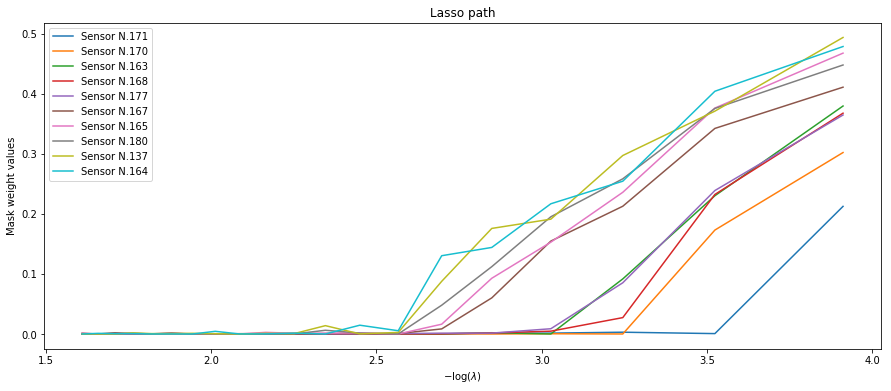

In [19]:
plt.rcParams["figure.figsize"] = (15,6)
plt.ion()
fig = plt.figure()
for i in range(10):     
    plt.plot(-np.log(Pi), weight_lda[:,i], label = 'Sensor N.{}'.format(I[i]))
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('Mask weight values')
plt.legend()
plt.title('Lasso path')

The lasso path of the first $10$ selected sensors. The lasso path is not smooth because there exists randomness in network training, also we don't use learning rate decay, so when the weights reach $0$, they will occilate around $0$. However, the lasso term in loss function is still useful for sensor selection. In practice, we consider the weights smaller than $1e-2$ as zero weights.

# Reconstruction performance on test set

In [20]:
X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
X_test_H  = np.empty((T_1-T_0-H,  N, H+1))

for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
    X_test_H[:,:,H-i]  = X_hour_detrend_sc[(T_0+H-i):(T_1-i),:]
    
Y_train = np.copy(X_train_H[:,I,H])
X_train_H[:,I,:] = 0.0
Y_val = np.copy(X_val_H[:,I,H])
X_val_H[:,I,:] = 0.0
Y_test = np.copy(X_test_H[:,I,H])
X_test_H[:,I,:] = 0.0

In [21]:
# Change some parameters for prediction network
params['batch_size']     = 2000
params['num_epochs']     = 50
params['M'][-1]          = P # Output dimension
params['learning_rate']  = 0.001

In [22]:
model = models.cgcnn(L, **params, selecting_mode = False)

NN architecture
  input: L_0 = 185
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 185 * 16 / 1 = 2960
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 185 * 16 = 2960
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 2960 * 128 = 378880
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 18
    weights: L_4 * L_5 = 64 * 18 = 1152
    biases: L_5 = 18
  Total number of trainable parameters: 480687
Adam optimizer is being used.


In [23]:
err_mse0 = np.zeros(10)
for x in range(10):
    _, _, _, _ = model.fit(train_data = X_train_H, train_targets = Y_train, val_data = X_val_H, val_targets = Y_val)
    _,Y_pred,_,_ = model.evaluate(X_test_H, Y_test)
    # The reconstruction error on test set
    err_mse0[x] = norm(Y_test - Y_pred)**2/Y_pred.shape[0]
    print(err_mse0[x])

epoch 1 (learning_rate = 1.00e-03):
  training_loss = 8.78e+00
  validation r2: -0.63, loss: 7.77e+00
  time: 3s (wall 2s)
epoch 2 (learning_rate = 1.00e-03):
  training_loss = 8.62e+00
  validation r2: -0.62, loss: 7.69e+00
  time: 6s (wall 4s)
epoch 3 (learning_rate = 1.00e-03):
  training_loss = 8.33e+00
  validation r2: -0.62, loss: 7.63e+00
  time: 8s (wall 5s)
epoch 4 (learning_rate = 1.00e-03):
  training_loss = 8.03e+00
  validation r2: -0.63, loss: 7.59e+00
  time: 11s (wall 7s)
epoch 5 (learning_rate = 1.00e-03):
  training_loss = 7.63e+00
  validation r2: -0.66, loss: 7.57e+00
  time: 13s (wall 8s)
epoch 6 (learning_rate = 1.00e-03):
  training_loss = 7.11e+00
  validation r2: -0.70, loss: 7.61e+00
  time: 15s (wall 10s)
epoch 7 (learning_rate = 1.00e-03):
  training_loss = 6.57e+00
  validation r2: -0.78, loss: 7.72e+00
  time: 18s (wall 11s)
 Training stopped for the validation loss has not decreased.
validation score: peak = -0.62, mean = -0.68
validation loss: min = 7.57

21.164656953203856
epoch 1 (learning_rate = 1.00e-03):
  training_loss = 8.75e+00
  validation r2: -0.59, loss: 7.68e+00
  time: 4s (wall 3s)
epoch 2 (learning_rate = 1.00e-03):
  training_loss = 8.54e+00
  validation r2: -0.57, loss: 7.55e+00
  time: 6s (wall 5s)
epoch 3 (learning_rate = 1.00e-03):
  training_loss = 8.24e+00
  validation r2: -0.55, loss: 7.43e+00
  time: 9s (wall 7s)
epoch 4 (learning_rate = 1.00e-03):
  training_loss = 7.82e+00
  validation r2: -0.53, loss: 7.32e+00
  time: 12s (wall 8s)
epoch 5 (learning_rate = 1.00e-03):
  training_loss = 7.29e+00
  validation r2: -0.52, loss: 7.20e+00
  time: 14s (wall 10s)
epoch 6 (learning_rate = 1.00e-03):
  training_loss = 6.77e+00
  validation r2: -0.52, loss: 7.11e+00
  time: 17s (wall 12s)
epoch 7 (learning_rate = 1.00e-03):
  training_loss = 6.15e+00
  validation r2: -0.54, loss: 7.07e+00
  time: 20s (wall 13s)
epoch 8 (learning_rate = 1.00e-03):
  training_loss = 5.54e+00
  validation r2: -0.60, loss: 7.15e+00
  time: 22s

In [24]:
err_mse0.mean()

20.719953316114868